# Notebook to make Fig. 4

In [1]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
from scipy.stats import gaussian_kde

import json
import random
import sys 
import os

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style

from helper_functions import *

style.use('plotting.mplstyle')

### Load data

In [2]:
# location of emcee samples
data_folder = '/home/simona.miller/comp-spin-mock-injections/Data/PopulationInferenceOutput/betaPlusGaussian/'
model = 'betaPlusGaussian'
numinjections = 70

# load emcee samples and put into dictionary labeled by population
all_emcee_data = {}
for pop_key in ['pop1', 'pop2', 'pop3']:
    
    name = f'{data_folder}betaPlusGaussian_{pop_key}_{numinjections}events_temp'
    
    with open(f'{name}.json', 'r') as f:
        pop_data = json.load(f)
        all_emcee_data[pop_key] = pop_data

In [3]:
# location of reweighted sample dicts (output of running posterior_reweighting)
rw_folder = '/home/zoe.ko/comp-spin-mock-injections/Data/PopulationInferenceOutput/betaPlusGaussian/'

# load reweighted event samples and put into dictionary labeled by population
all_sampleDicts_rw = {}
for pop_key in['pop1', 'pop2', 'pop3']:
    
    sampleDict = np.load(rw_folder + str(numinjections) + model + '_' + pop_key + 'rw_sampleDict.pickle', allow_pickle=True)
    all_sampleDicts_rw[pop_key] = sampleDict

### Generate predicted versus observed draws from populations

In [4]:
if os.path.exists('predicted_spins_dict_pp.json') and os.path.exists('observed_spins_dict_pp.json'): 
    
    # Load in the predicted and observed draws if they already exist 
    with open('predicted_spins_dict_pp.json', 'r') as f: 
        pred_spins = json.load(f)
    with open('observed_spins_dict_pp.json', 'r') as f: 
        obs_spins = json.load(f)

else: 
    
    # Create dicts for predicted versus observed "catalogs" 
    pred_spins = {}
    obs_spins = {}

    # Cycle through populations
    for k, pop_key in enumerate(['pop1', 'pop2', 'pop3']):
        
        # Number of catalogs to create
        nCatalogs = 1000

        # Print progress
        print(pop_key)

        # Fetch emcee data for this population
        data = all_emcee_data[pop_key]

        # Create arrays in which to store the predicted spin parameters
        chi1_pred = np.zeros((nCatalogs, numinjections))
        chi2_pred = np.zeros((nCatalogs, numinjections))
        cost1_pred = np.zeros((nCatalogs, numinjections))
        cost2_pred = np.zeros((nCatalogs, numinjections))
        chieff_pred = np.zeros((nCatalogs, numinjections))
        chip_pred = np.zeros((nCatalogs, numinjections))

        # And the observed spin parameters 
        chi1_obs = np.zeros((nCatalogs, numinjections))
        chi2_obs = np.zeros((nCatalogs, numinjections))
        cost1_obs = np.zeros((nCatalogs, numinjections))
        cost2_obs = np.zeros((nCatalogs, numinjections))
        chieff_obs = np.zeros((nCatalogs, numinjections))
        chip_obs = np.zeros((nCatalogs, numinjections))
        
        # Generate nCatalog instantiations of "catalogs"
        for run in np.arange(nCatalogs):

            '''
            "Predicted" spins
            '''
            
            # Choose numinjections hyperparameters and draw a sample from each corresponding distribution
            random_indices = np.random.choice(np.arange(len(data['mu_chi']['processed'])), size=numinjections,replace=False)

            for i,ind in enumerate(random_indices):

                # Fetch parameters 
                mu_chi = data['mu_chi']['processed'][ind]
                sigma_chi = data['sigma_chi']['processed'][ind]
                mu_cost = data['mu_cost']['processed'][ind]
                sigma_cost = data['sigma_cost']['processed'][ind]
                Bq = data['Bq']['processed'][ind]

                # transform from mu and sigma to a and b for beta distribution
                a, b = mu_sigma2_to_a_b(mu_chi, sigma_chi**2)

                # draw uniform component spins + masses
                nRandomDraws = 10000
                samp_idxs = np.arange(nRandomDraws)
                chi1s = np.random.rand(nRandomDraws)
                chi2s = np.random.rand(nRandomDraws)
                cost1s = np.random.rand(nRandomDraws)*2 - 1
                cost2s = np.random.rand(nRandomDraws)*2 - 1
                mAs = np.random.rand(nRandomDraws)*100
                mBs = np.random.rand(nRandomDraws)*100
                m1s = np.maximum(mAs, mBs)
                m2s = np.minimum(mAs, mBs)

                # Calculate weights
                p_chi1 = calculate_betaDistribution(chi1s, a, b)
                p_chi2 = calculate_betaDistribution(chi2s, a, b)
                p_cost1 = calculate_Gaussian_1D(cost1s, mu_cost, sigma_cost, -1, 1)
                p_cost2 = calculate_Gaussian_1D(cost2s, mu_cost, sigma_cost, -1, 1)
                p_masses = p_astro_masses(m1s, m2s, bq=Bq)

                weights = p_chi1*p_chi2*p_cost1*p_cost2*p_masses
                weights_normed = weights/np.sum(weights)
                weights_normed[np.where(weights_normed<0)] = 0 # get rid of tiny division errors

                # Select a sample with probabilities given by the normalized weights
                idx = np.random.choice(samp_idxs, p=weights_normed, size=1) 
                chi1 = chi1s[idx]
                chi2 = chi2s[idx]
                cost1 = cost1s[idx]
                cost2 = cost2s[idx]
                
                # Calculate chi_eff 
                q = m2s[idx]/m1s[idx]
                chi_eff = calculate_chiEff(chi1, chi2, cost1, cost2, q)
                
                # Calculate chi_p
                sint1 = np.sin(np.arccos(cost1))
                sint2 = np.sin(np.arccos(cost2))
                chi_p = calculate_chiP(chi1, chi2, sint1, sint2, q)

                # Add to arrays
                chi1_pred[run,i] = chi1
                chi2_pred[run,i] = chi2
                cost1_pred[run,i] = cost1
                cost2_pred[run,i] = cost2
                chieff_pred[run,i] = chi_eff
                chip_pred[run,i] = chi_p


            '''
            Observed spins
            '''
            
            # Load reweighted individual event samples
            sampleDict_rw = all_sampleDicts_rw[pop_key]

            # Cycle through events
            for j, event_key in enumerate(sampleDict_rw.keys()):
                                
                d = sampleDict_rw[event_key]

                # Select a random sample
                idx = random.choice(np.arange(d['chi1'].size))
                chi1 = d['chi1'][idx]
                chi2 = d['chi2'][idx]
                cost1 = d['cost1'][idx]
                cost2 = d['cost2'][idx]
                
                # Calculate chi_eff
                q = d['m2'][idx]/d['m1'][idx]
                chi_eff = calculate_chiEff(chi1, chi2, cost1, cost2, q)
                
                # Calculate chi_p
                sint1 = np.sin(np.arccos(cost1))
                sint2 = np.sin(np.arccos(cost2))
                chi_p = calculate_chiP(chi1, chi2, sint1, sint2, q)

                # Add to arrays
                chi1_obs[run,j] = chi1
                chi2_obs[run,j] = chi2
                cost1_obs[run,j] = cost1
                cost2_obs[run,j] = cost2
                chieff_obs[run,j] = chi_eff
                chip_obs[run,j] = chi_p

        # Add results to dicts 
        pred_spins[pop_key] = {
            'chi1':chi1_pred.tolist(),
            'chi2':chi2_pred.tolist(),
            'cost1':cost1_pred.tolist(),
            'cost2':cost2_pred.tolist(),
            'chieff':chieff_pred.tolist(), 
            'chip':chip_pred.tolist()
        }
        obs_spins[pop_key] = {
            'chi1':chi1_obs.tolist(),
            'chi2':chi2_obs.tolist(),
            'cost1':cost1_obs.tolist(),
            'cost2':cost2_obs.tolist(),
            'chieff':chieff_obs.tolist(), 
            'chip':chip_obs.tolist()
        }

    print('Done!')

Save traces to be used to make Fig. 5 and to reload later here if needed

In [5]:
with open('predicted_spins_dict_pp.json', "w") as f:
    json.dump(pred_spins, f)
    
with open('observed_spins_dict_pp.json', "w") as f:
    json.dump(obs_spins, f)

### Make figure

In [6]:
# Labels corresponding to each pop
labels_dict = {
    'pop1':r'$\mathrm{\textsc{HighSpinPrecessing}}$', 
    'pop2':r'$\mathrm{\textsc{MediumSpin}}$', 
    'pop3':r'$\mathrm{\textsc{LowSpinAligned}}$'
}

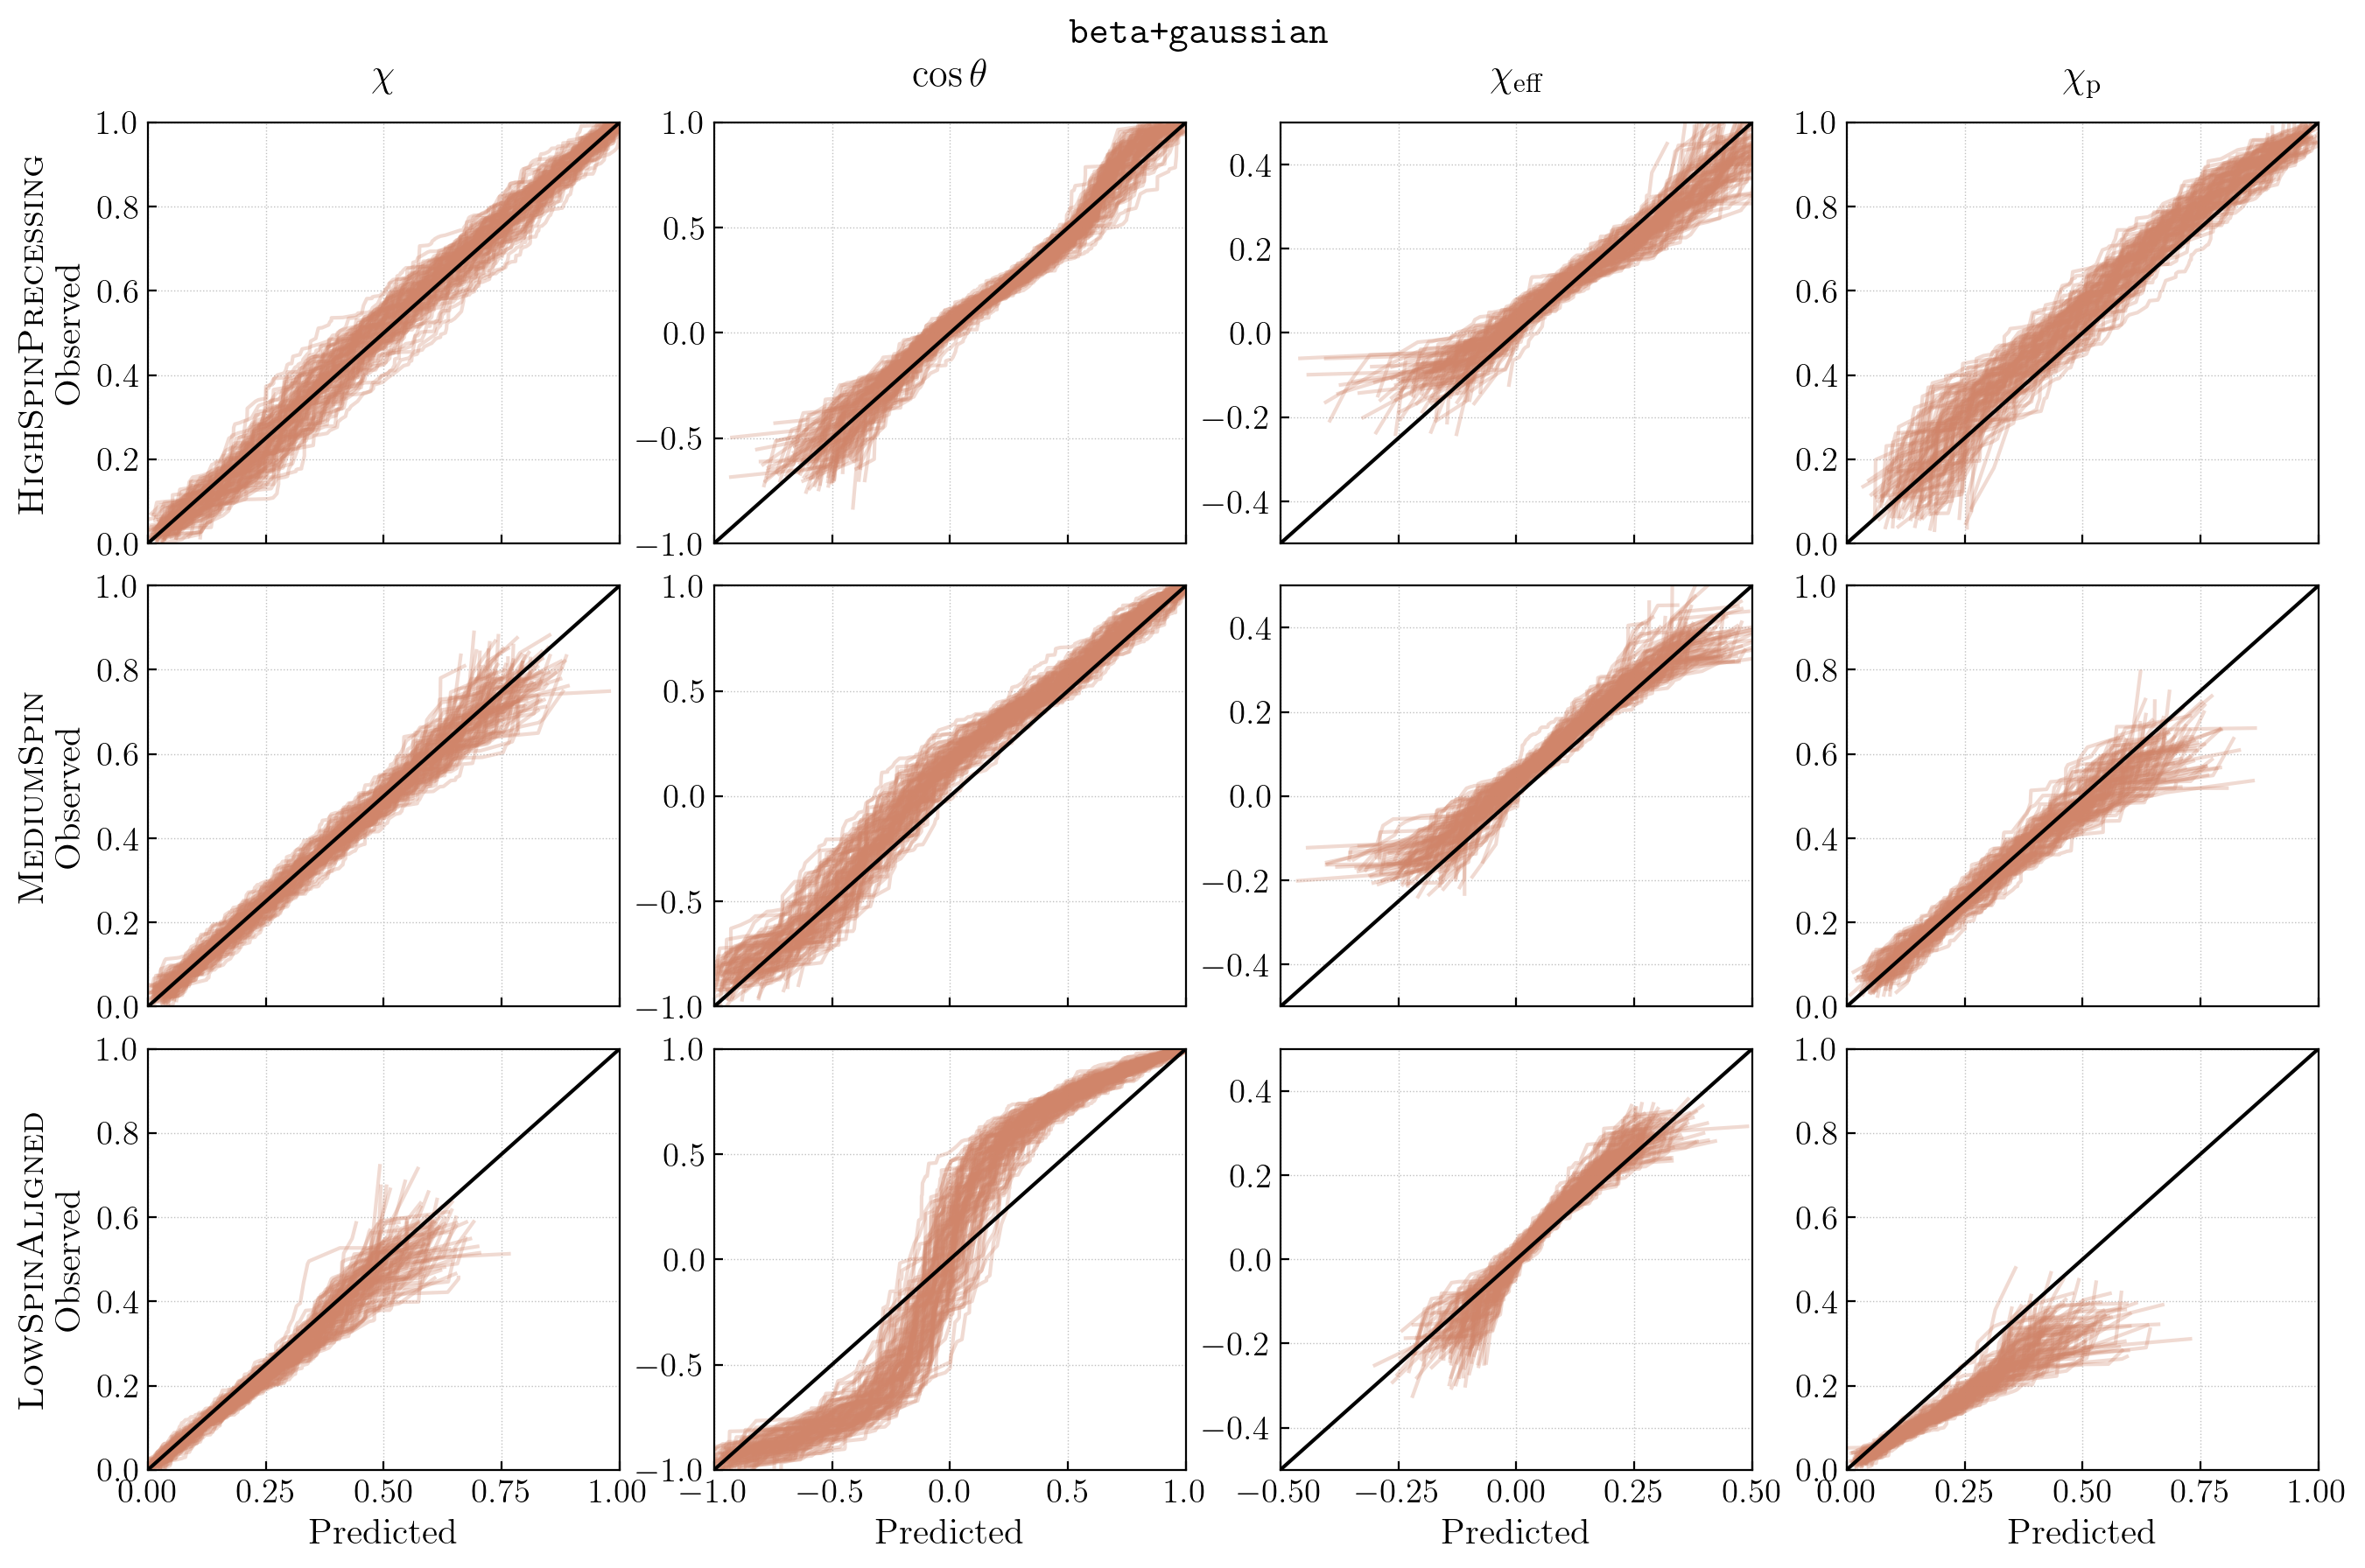

In [7]:
nCatalogs_to_plot = 100

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,10))

for i,key in enumerate(['pop1', 'pop2', 'pop3']):
    
    # spin magnitudes
    for j in range(nCatalogs_to_plot):
        chi_pred = np.concatenate((pred_spins[key]['chi1'][j], pred_spins[key]['chi2'][j]))
        chi_obs = np.concatenate((obs_spins[key]['chi1'][j], obs_spins[key]['chi2'][j]))
        axes[i][0].plot(np.sort(chi_pred), np.sort(chi_obs), alpha=0.3, c='#d0856a')
    axes[i][0].plot([0, 1], [0, 1], color='k') # diagonal line
    axes[i][0].set_xlim(0,1)
    axes[i][0].set_ylim(0,1)
    
    # tilt angles
    for j in range(nCatalogs_to_plot):
        cost_pred = np.concatenate((pred_spins[key]['cost1'][j], pred_spins[key]['cost2'][j]))
        cost_obs = np.concatenate((obs_spins[key]['cost1'][j], obs_spins[key]['cost2'][j]))
        axes[i][1].plot(np.sort(cost_pred), np.sort(cost_obs), alpha=0.3, c='#d0856a')
    axes[i][1].plot([-1, 1], [-1, 1], color='k')
    axes[i][1].set_xlim(-1,1)
    axes[i][1].set_ylim(-1,1)
    
    # chieff
    for j in range(nCatalogs_to_plot):
        axes[i][2].plot(np.sort(pred_spins[key]['chieff'][j]), np.sort(obs_spins[key]['chieff'][j]), alpha=0.3, c='#d0856a')
    axes[i][2].plot([-1, 1], [-1, 1], color='k')
    axes[i][2].set_xlim(-0.5, 0.5)
    axes[i][2].set_ylim(-0.5, 0.5)
    
    # chip
    for j in range(nCatalogs_to_plot):
        axes[i][3].plot(np.sort(pred_spins[key]['chip'][j]), np.sort(obs_spins[key]['chip'][j]), alpha=0.3, c='#d0856a')
    axes[i][3].plot([0, 1], [0, 1], color='k')
    axes[i][3].set_xlim(0,1)
    axes[i][3].set_ylim(0,1)
    
    # set label
    axes[i][0].set_ylabel(f'{labels_dict[key]}\nObserved', fontsize=15)
        
    if i!=2: 
        for ax in axes[i]: 
            ax.set_xticklabels([])
    else: 
        for ax in axes[i]: 
            ax.set_xlabel('Predicted', fontsize=15)
    
axes[0][0].set_title(r'$\chi$', fontsize=16, y=1.05)
axes[0][1].set_title(r'$\cos\theta$', fontsize=16, y=1.05)
axes[0][2].set_title(r'$\chi_\mathrm{eff}$', fontsize=16, y=1.05)
axes[0][3].set_title(r'$\chi_\mathrm{p}$', fontsize=16, y=1.05)

for ax in axes: 
    for a in ax:
        a.grid(ls=':', color='silver', lw=0.5)
        
plt.subplots_adjust(hspace=0.1)

plt.suptitle(r'$\mathrm{\texttt{beta+gaussian}}$', fontsize=16, y=0.94)

plt.savefig('figure_04_temp.pdf', bbox_inches='tight')
plt.show()